# MPI calibration of a Grid5000 cluster

## Data exploration

In [1]:
import os
import zipfile
import yaml
import pandas
import io
import plotnine
plotnine.options.figure_size = (12, 8)
from plotnine import *
import matplotlib.pyplot as plt
import pytree
print(f'pytree {pytree.__version__}')
print(f'pytree {pytree.__git_version__}')

remote_archive   = 'large_calibration/grenoble_2020-08-13_1944311.zip'
loopback_archive = 'large_calibration/grenoble_2020-08-13_1944312.zip'

threshold = 64000  # "semantic" breakpoint, found with another script

# I really hate that we have to define these two values:
expected_bandwidth = 1e11/8
expected_latency   = 1e-7

expected_loopback_bandwidth = 2e11/8
expected_loopback_latency = 1e-7

def extract_zip(zip_name):
    '''Taken from https://stackoverflow.com/a/10909016/4110059'''
    input_zip = zipfile.ZipFile(zip_name)
    result = {}
    deployment = yaml.load(input_zip.read('info.yaml'), Loader=yaml.BaseLoader)['deployment']
    experiment = zip_name
    if '/' in experiment:
        experiment = experiment[experiment.index('/')+1:]
    experiment = experiment[:experiment.index('_')]
    for name in input_zip.namelist():
        if name.endswith('.csv'):
            dataframe = pandas.read_csv(io.BytesIO(input_zip.read(name)), names = ['op', 'msg_size', 'start', 'duration'])
            dataframe['experiment'] = experiment
            dataframe['type'] = name
            dataframe['deployment'] = deployment
            dataframe['index'] = range(len(dataframe))
            result[name] = dataframe
        elif name.endswith('.yaml'):
            result[name] = yaml.load(input_zip.read(name), Loader=yaml.BaseLoader)
        else:
            result[name] = input_zip.read(name)
    return result

def aggregate_dataframe(dataframe):
    df = dataframe.groupby('msg_size').mean().reset_index()
    for col in dataframe.columns:
        if col not in df.columns:
            value = list(dataframe[col].unique())
            if len(value) == 1:
                df[col] = value[0]
    return df

def load_experiment(zip_name, exp_name=None):
    result = extract_zip(zip_name)
    # Special processing for the Pingpong dataset
    df_pingpong = result['exp/exp_PingPong.csv']
    pingpong_send = df_pingpong[df_pingpong.op=='MPI_Send'].reset_index(drop=True)
    pingpong_recv = df_pingpong[df_pingpong.op=='MPI_Recv'].reset_index(drop=True)
    df_pingpong = pandas.DataFrame(dict(op = 'PingPong',
                       msg_size = pingpong_send.msg_size,
                       start    = pingpong_send.start,
                       duration = pingpong_recv.duration + pingpong_send.duration
                  ))
    result = {
        'pingpong': df_pingpong,
        'send'  : pingpong_send,
        'isend' : result['exp/exp_Isend.csv'],
        'recv'  : result['exp/exp_Recv.csv'],
        'wtime' : result['exp/exp_Wtime.csv'],
        'test'  : result['exp/exp_Test.csv'],
        'iprobe': result['exp/exp_Iprobe.csv'],
    }
    if exp_name is not None:
        for df in result.values():
            df['experiment'] = exp_name
    return result

pytree 0.0.6
pytree daeffcbfbfb10dc9d69044bb110f965ab4e4e042


In [2]:
remote   = load_experiment(remote_archive, exp_name='remote')
loopback = load_experiment(loopback_archive, exp_name='loopback')

### First visualization of the pingpong durations

/home/tom/.cache/pypoetry/virtualenvs/mpi-calibration-V_fyVHYp-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 12 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/tom/.cache/pypoetry/virtualenvs/mpi-calibration-V_fyVHYp-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /tmp/pingpong_duration.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


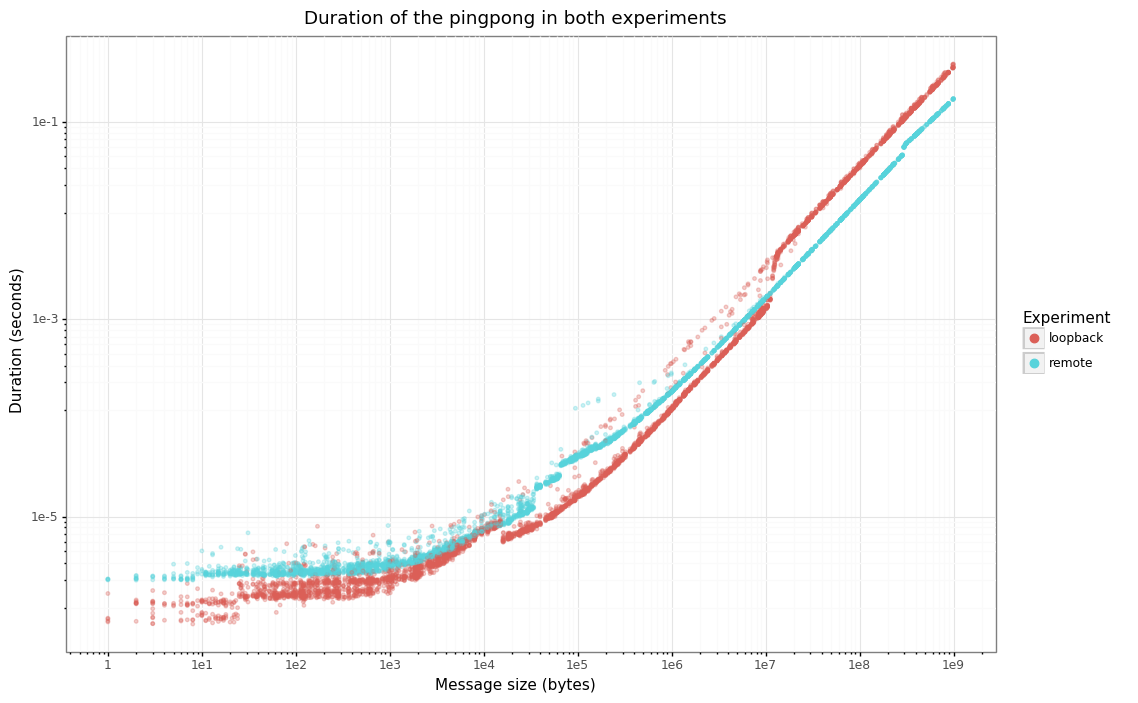

<ggplot: (8763125297135)>

In [3]:
tmp = pandas.concat([remote['pingpong'], loopback['pingpong']])
plot = (ggplot(tmp.sample(n=10000))
    + aes(x='msg_size', y='duration', color='experiment')
    + geom_point(alpha=0.3, size=1)
    + scale_x_log10(breaks=[10**n for n in range(10)])
    + scale_y_log10()
    + theme_bw()
    + ggtitle('Duration of the pingpong in both experiments')
    + labs(x='Message size (bytes)', y='Duration (seconds)', color='Experiment')
    + guides(color = guide_legend(override_aes = {'alpha': 1, 'size': 3}))
)
plot.save('/tmp/pingpong_duration.png')
plot

/home/tom/.cache/pypoetry/virtualenvs/mpi-calibration-V_fyVHYp-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 12 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/tom/.cache/pypoetry/virtualenvs/mpi-calibration-V_fyVHYp-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /tmp/pingpong_bandwidth.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


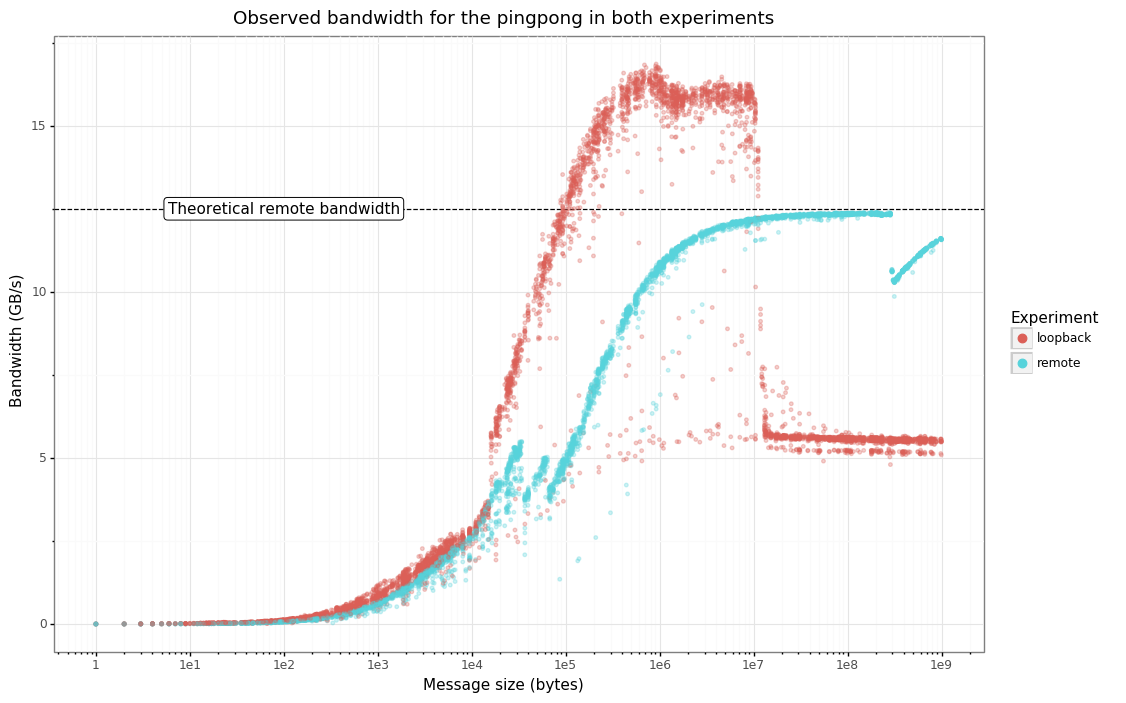

<ggplot: (8763021972130)>

In [4]:
tmp['bandwidth'] = 2*tmp['msg_size'] / tmp['duration'] * 1e-9
plot = (ggplot(tmp.sample(n=10000))
    + aes(x='msg_size', y='bandwidth', color='experiment')
    + geom_hline(yintercept=expected_bandwidth*1e-9, linetype='dashed')
    + annotate('label', label='Theoretical remote bandwidth', x=100, y=expected_bandwidth*1e-9)
    + geom_point(alpha=0.3, size=1)
    + scale_x_log10(breaks=[10**n for n in range(10)])
    + theme_bw()
    + ggtitle('Observed bandwidth for the pingpong in both experiments')
    + labs(x='Message size (bytes)', y='Bandwidth (GB/s)', color='Experiment')
    + guides(color = guide_legend(override_aes = {'alpha': 1, 'size': 3}))
)
plot.save('/tmp/pingpong_bandwidth.png')
plot

### MPI_Send

In [5]:
import pytree

tmp = aggregate_dataframe(remote['send'])
reg_send = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration)
print(reg_send.breakpoints)
reg_send = reg_send.auto_simplify()
print(reg_send.breakpoints)
reg_send

[9, 3701, 8141, 33975, 63785, 194411252, 214537334, 281759193, 285420699, 306119615]
[63785, 214537334, 281759193, 285420699, 306119615]


-inf < x ≤ 6.378e+04
	y ~ 2.770e-10x + 7.959e-08
6.378e+04 < x ≤ 2.145e+08
	y ~ 8.089e-11x + 1.593e-05
2.145e+08 < x ≤ 2.818e+08
	y ~ 8.086e-11x + 6.312e-05
2.818e+08 < x ≤ 2.854e+08
	y ~ 3.190e-10x + -6.780e-02
2.854e+08 < x ≤ 3.061e+08
	y ~ 2.781e-10x + -5.077e-02
3.061e+08 < x ≤ inf
	y ~ 8.090e-11x + 1.016e-02

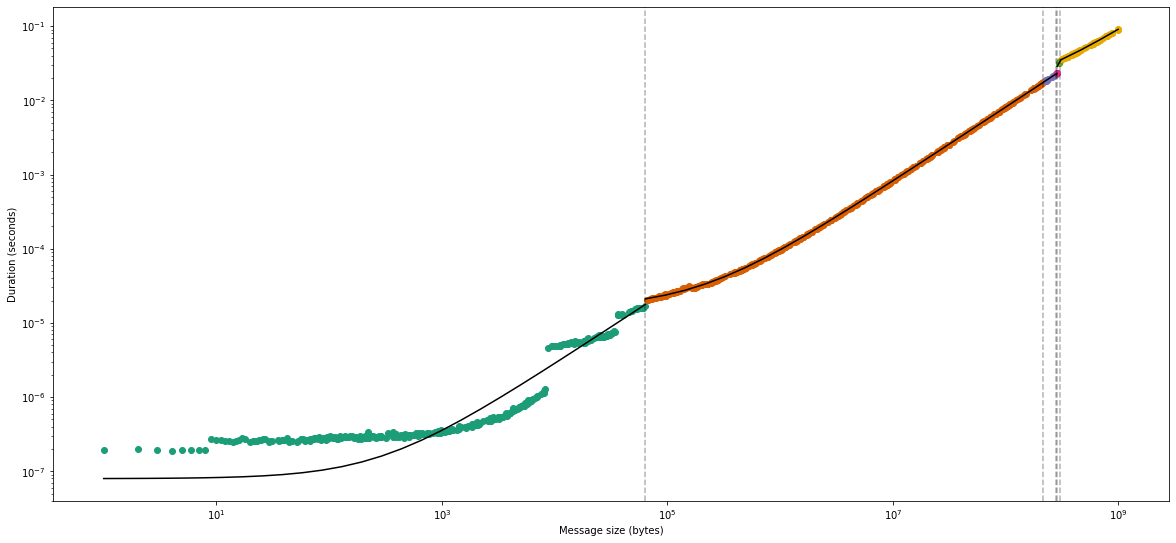

In [6]:
def draw_plot(reg, alpha=1):
    reg.plot_dataset(log=True, alpha=alpha)
    plt.xlabel('Message size (bytes)')
    plt.ylabel('Duration (seconds)')

draw_plot(reg_send)

Well, the above auto-simplify did not work at all, it removed important breakpoints and kept useless ones... So, let's just define our own breakpoints.

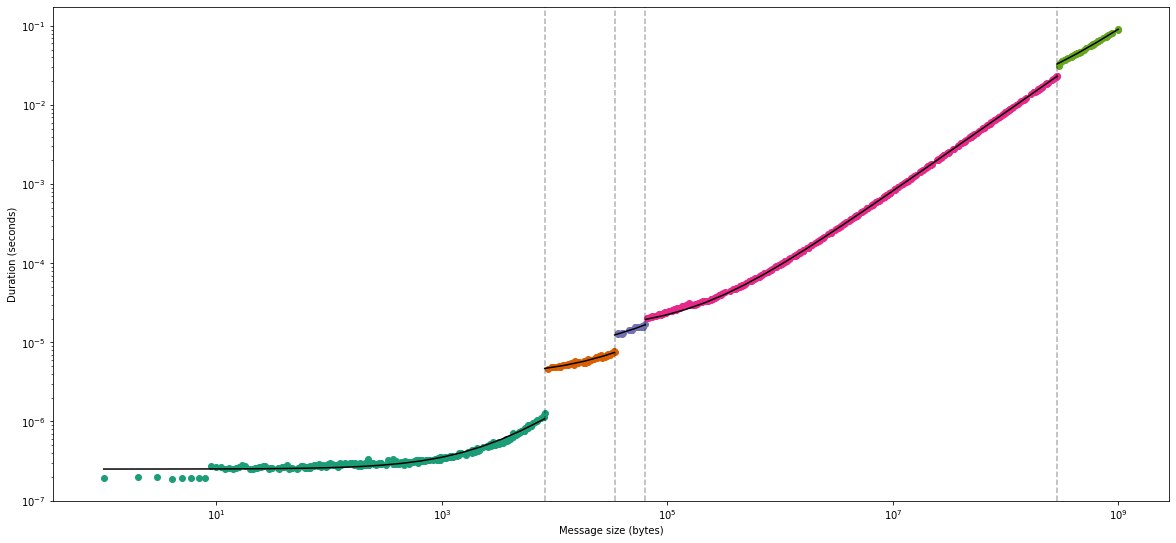

In [7]:
breakpoints_send = [8141, 33975, 63785, 285420699]
draw_plot(pytree.compute_regression(x=tmp.msg_size, y=tmp.duration, breakpoints=breakpoints_send))
breakpoints_send = set(breakpoints_send)

### MPI_Isend

In [8]:
tmp = aggregate_dataframe(remote['isend'])
reg_isend = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration).auto_simplify()
print(reg_isend.breakpoints)
reg_isend

[15182, 63785, 210183779]


-inf < x ≤ 1.518e+04
	y ~ 8.664e-11x + 7.540e-07
1.518e+04 < x ≤ 6.378e+04
	y ~ 3.278e-11x + 3.320e-06
6.378e+04 < x ≤ 2.102e+08
	y ~ 3.009e-15x + 8.636e-07
2.102e+08 < x ≤ inf
	y ~ 1.449e-16x + 1.521e-06

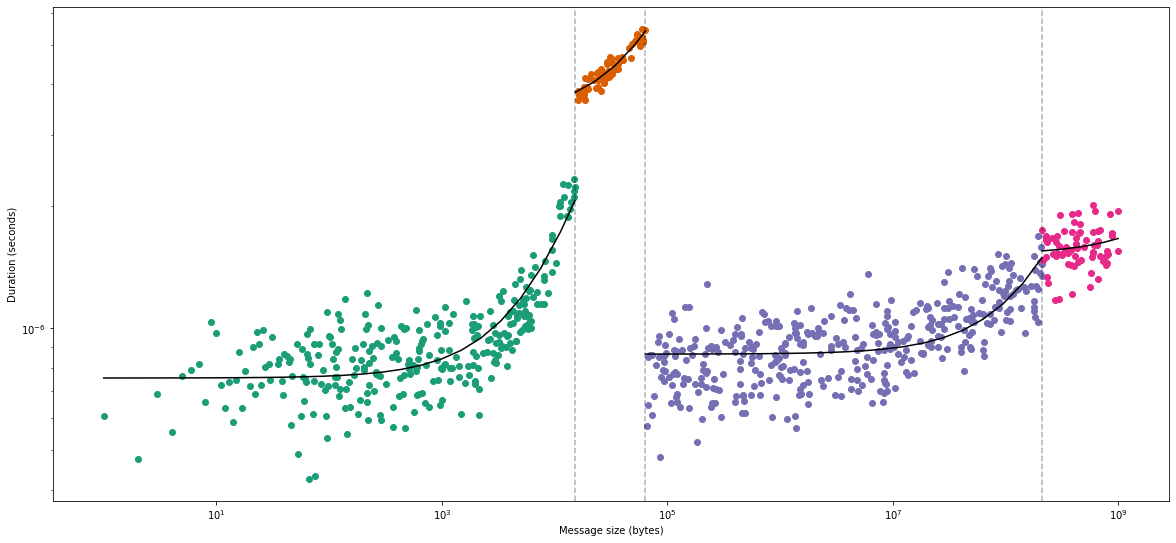

In [9]:
draw_plot(reg_isend)

In [10]:
breakpoints_isend = set(reg_isend.breakpoints)
breakpoints_isend

{15182, 63785, 210183779}

### MPI_Recv

In [11]:
tmp = aggregate_dataframe(remote['recv'])
reg_recv = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration).auto_simplify()
print(reg_recv.breakpoints)
reg_recv

[63785, 22348146, 205328065, 385678007, 416442661, 882036063]


-inf < x ≤ 6.378e+04
	y ~ 7.418e-11x + 1.251e-06
6.378e+04 < x ≤ 2.235e+07
	y ~ 8.119e-11x + 9.760e-06
2.235e+07 < x ≤ 2.053e+08
	y ~ 8.083e-11x + 1.823e-05
2.053e+08 < x ≤ 3.857e+08
	y ~ 8.082e-11x + 7.221e-05
3.857e+08 < x ≤ 4.164e+08
	y ~ 8.080e-11x + 1.480e-04
4.164e+08 < x ≤ 8.820e+08
	y ~ 8.086e-11x + 3.976e-04
8.820e+08 < x ≤ inf
	y ~ 1.143e-10x + -3.239e-02

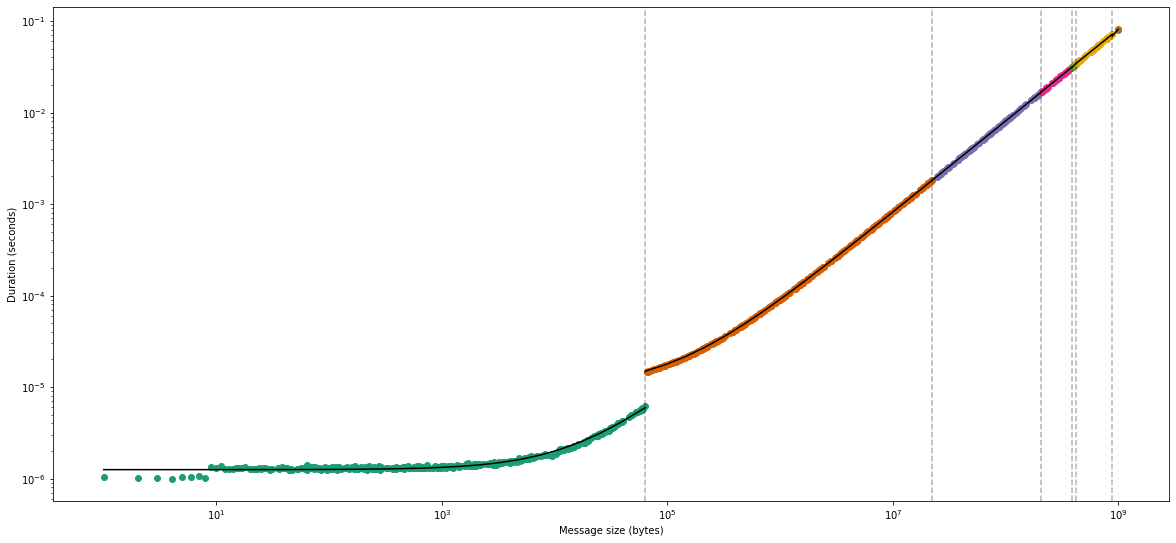

In [12]:
draw_plot(reg_recv)

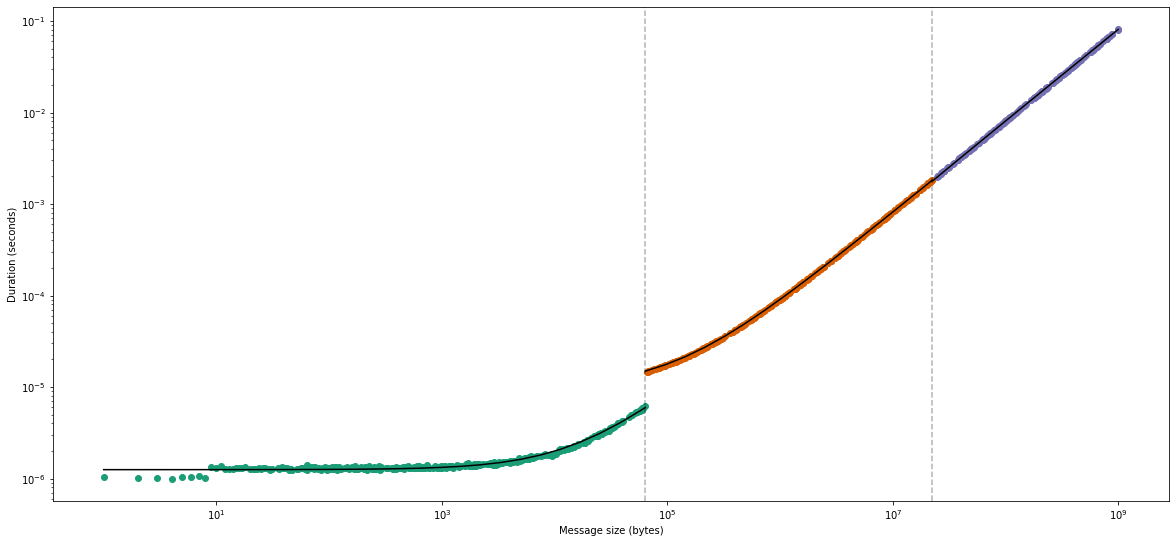

In [13]:
breakpoints_recv = list(sorted(set(reg_recv.breakpoints) - {205328065, 385678007, 416442661, 882036063}))
draw_plot(pytree.compute_regression(x=tmp.msg_size, y=tmp.duration, breakpoints=breakpoints_recv))
breakpoints_recv = set(breakpoints_recv)

### Pingpong

In [14]:
tmp = aggregate_dataframe(remote['pingpong'])
reg_pingpong = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration)
print(reg_pingpong.breakpoints)
reg_pingpong = reg_pingpong.auto_simplify()
print(reg_pingpong.breakpoints)
reg_pingpong

[9467, 33975, 63785, 159291, 18586921, 107830589, 205328065, 281759193, 285420699, 306119615]
[63785, 205328065, 285420699, 306119615]


-inf < x ≤ 6.378e+04
	y ~ 3.805e-10x + 3.010e-06
6.378e+04 < x ≤ 2.053e+08
	y ~ 1.618e-10x + 2.724e-05
2.053e+08 < x ≤ 2.854e+08
	y ~ 1.629e-10x + -1.504e-04
2.854e+08 < x ≤ 3.061e+08
	y ~ 3.590e-10x + -5.072e-02
3.061e+08 < x ≤ inf
	y ~ 1.625e-10x + 1.006e-02

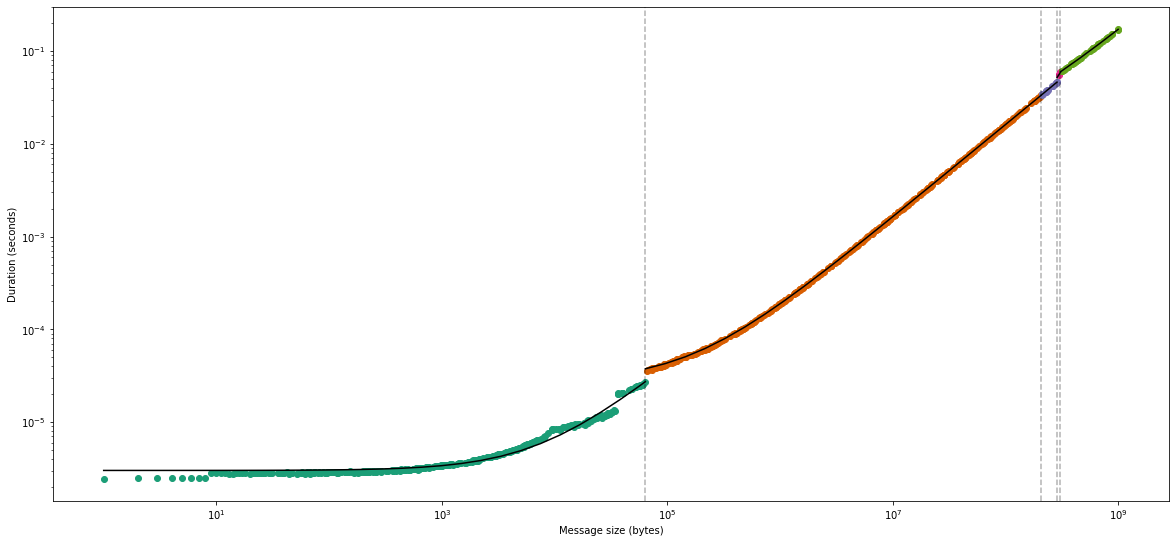

In [15]:
draw_plot(reg_pingpong)

[9467, 33975, 63785, 285420699]


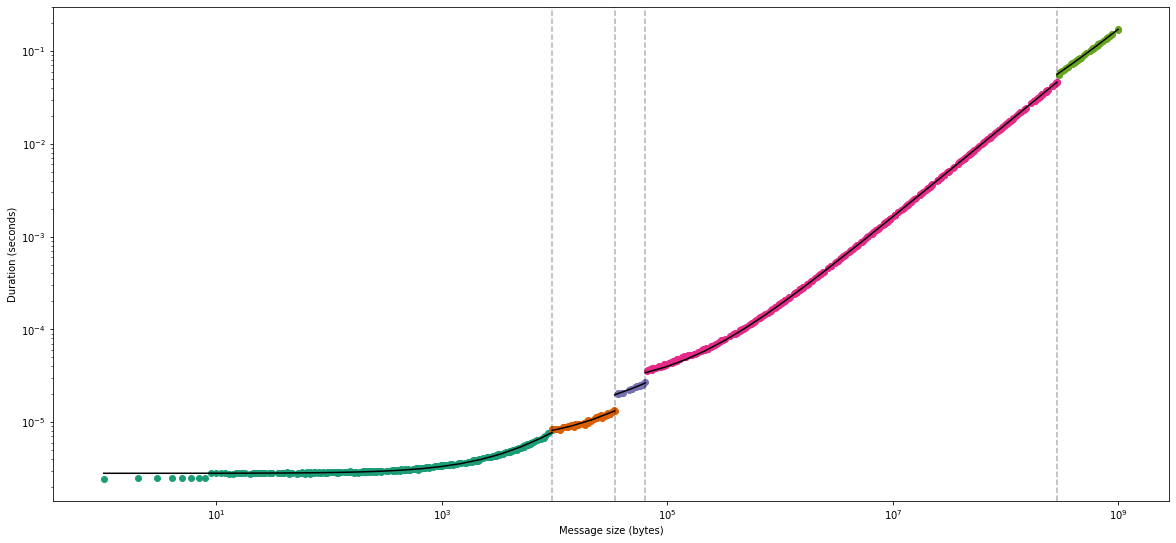

In [16]:
breakpoints_pingpong = list(sorted((set(reg_pingpong.breakpoints) | {9467, 33975}) - {205328065, 306119615}))
draw_plot(pytree.compute_regression(x=tmp.msg_size, y=tmp.duration, breakpoints=breakpoints_pingpong))
print(breakpoints_pingpong)
breakpoints_pingpong = set(breakpoints_pingpong)

## Better regressions

Let's use the same breakpoints everywhere.

In [17]:
breakpoints = list(sorted(set.union(breakpoints_send, breakpoints_isend, breakpoints_recv, breakpoints_pingpong)))
breakpoints

[8141, 9467, 15182, 33975, 63785, 22348146, 210183779, 285420699]

In [18]:
breakpoints.remove(9467)
breakpoints.remove(210183779)
breakpoints[breakpoints.index(63785)] = 64000
assert threshold in breakpoints
breakpoints

[8141, 15182, 33975, 64000, 22348146, 285420699]

In [19]:
def my_join(*values, inner_sep=':', outer_sep=';'):
    result = []
    for items in zip(*values):
        result.append(inner_sep.join([str(it) for it in items]))
    return outer_sep.join(result)

def regression_to_str(reg_df, drop_threshold=None, keys=['intercept', 'coefficient']):
    if drop_threshold is not None:
        reg_df.loc[reg_df.min_x >= drop_threshold, 'intercept'] = 0
        reg_df.loc[reg_df.min_x >= drop_threshold, 'coefficient'] = 0
    reg_df.loc[reg_df.min_x < 0, 'min_x'] = 0
    reg_df.min_x = reg_df.min_x.astype(int)
    reg_df.loc[reg_df.coefficient < 0, 'coefficient'] = 0
    reg_df.loc[reg_df.intercept < 0, 'intercept'] = 0
    reg_df.sort_values(by='min_x')
    values = [reg_df.min_x]
    for key in keys:
        values.append(reg_df[key])
    return my_join(*values)

### MPI_Send

-inf < x ≤ 8.141e+03
	y ~ 1.025e-10x + 2.503e-07
8.141e+03 < x ≤ 1.518e+04
	y ~ 1.333e-10x + 3.539e-06
1.518e+04 < x ≤ 3.398e+04
	y ~ 1.145e-10x + 3.614e-06
3.398e+04 < x ≤ 6.400e+04
	y ~ 1.458e-10x + 7.443e-06
6.400e+04 < x ≤ 2.235e+07
	y ~ 8.090e-11x + 1.593e-05
2.235e+07 < x ≤ 2.854e+08
	y ~ 8.104e-11x + 5.058e-06
2.854e+08 < x ≤ inf
	y ~ 8.157e-11x + 9.702e-03


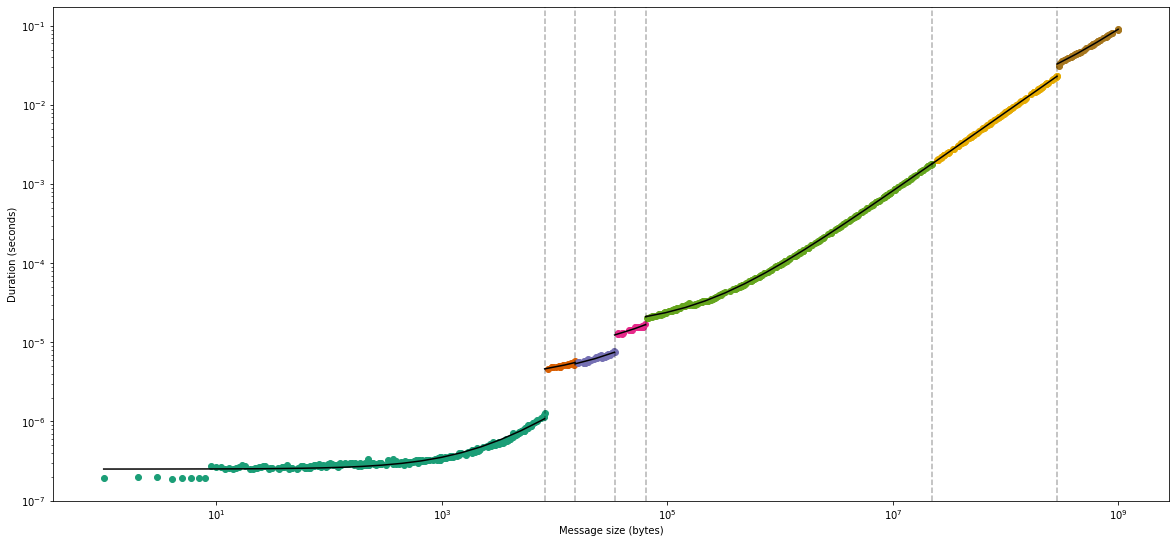

In [20]:
tmp = aggregate_dataframe(remote['send'])
reg_send = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration, breakpoints=breakpoints)
print(reg_send)
draw_plot(reg_send)

In [21]:
reg_send_str = regression_to_str(reg_send.to_pandas(), drop_threshold=threshold)
reg_send_str

'0:2.502937424977244e-07:1.0245080259848237e-10;8141:3.539145436769647e-06:1.3325898763631872e-10;15182:3.614469229804382e-06:1.145222660235552e-10;33975:7.442771050909496e-06:1.45750515221467e-10;64000:0.0:0.0;22348146:0.0:0.0;285420699:0.0:0.0'

### MPI_Isend

-inf < x ≤ 8.141e+03
	y ~ 6.213e-11x + 7.839e-07
8.141e+03 < x ≤ 1.518e+04
	y ~ 1.200e-10x + 4.747e-07
1.518e+04 < x ≤ 3.398e+04
	y ~ 3.924e-11x + 3.163e-06
3.398e+04 < x ≤ 6.400e+04
	y ~ 3.108e-11x + 3.398e-06
6.400e+04 < x ≤ 2.235e+07
	y ~ 8.230e-15x + 8.293e-07
2.235e+07 < x ≤ 2.854e+08
	y ~ 2.048e-15x + 9.929e-07
2.854e+08 < x ≤ inf
	y ~ 1.220e-16x + 1.537e-06


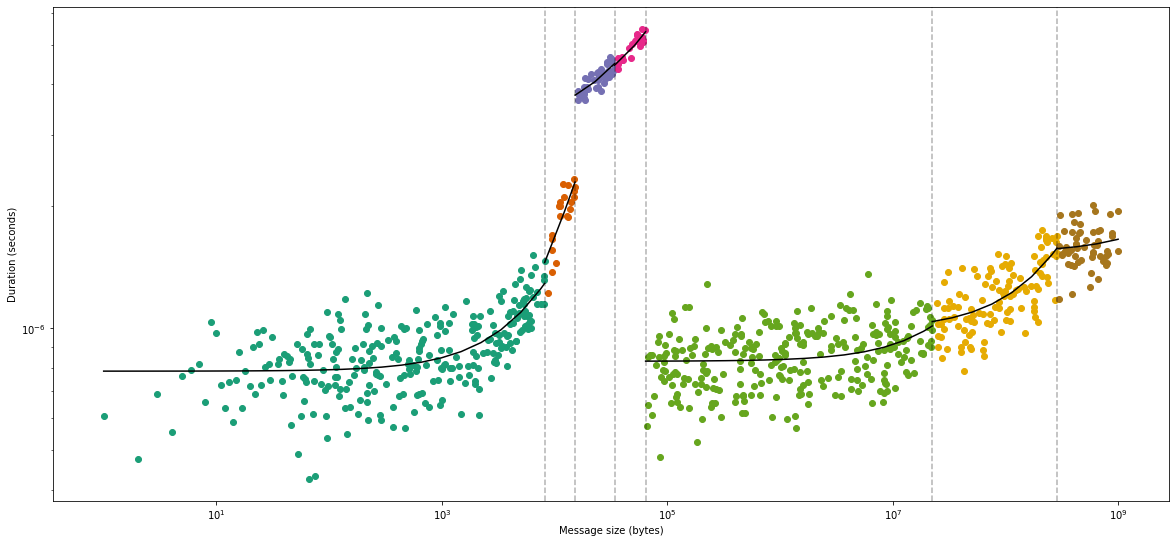

In [22]:
tmp = aggregate_dataframe(remote['isend'])
reg_isend = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration, breakpoints=breakpoints)
print(reg_isend)
draw_plot(reg_isend)

In [23]:
reg_isend_str = regression_to_str(reg_isend.to_pandas())
reg_isend_str

'0:7.839303208881308e-07:6.213245167151483e-11;8141:4.7465736494455546e-07:1.1998589881677183e-10;15182:3.1633105340707003e-06:3.9237056543152315e-11;33975:3.398018956917037e-06:3.108376556546846e-11;64000:8.292606576826348e-07:8.229713360921498e-15;22348146:9.929024202226972e-07:2.048446537316319e-15;285420699:1.5372126903753094e-06:1.2198905891978087e-16'

### MPI_Recv

-inf < x ≤ 8.141e+03
	y ~ 6.626e-11x + 1.275e-06
8.141e+03 < x ≤ 1.518e+04
	y ~ 7.777e-11x + 1.117e-06
1.518e+04 < x ≤ 3.398e+04
	y ~ 7.539e-11x + 1.144e-06
3.398e+04 < x ≤ 6.400e+04
	y ~ 7.893e-11x + 1.099e-06
6.400e+04 < x ≤ 2.235e+07
	y ~ 8.119e-11x + 9.760e-06
2.235e+07 < x ≤ 2.854e+08
	y ~ 8.102e-11x + 5.547e-06
2.854e+08 < x ≤ inf
	y ~ 8.156e-11x + -8.906e-05


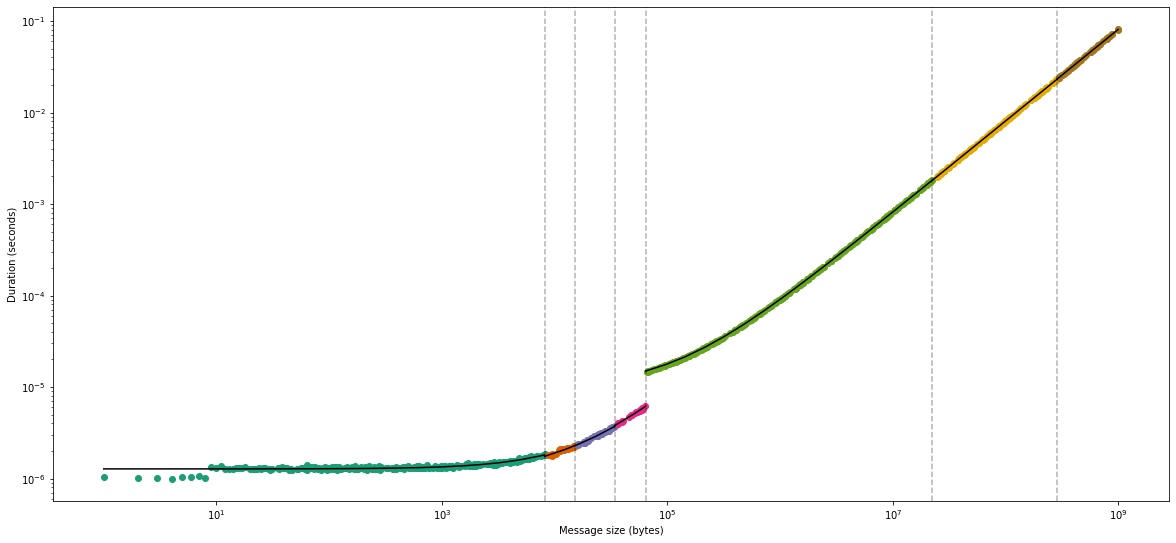

In [24]:
tmp = aggregate_dataframe(remote['recv'])
reg_recv = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration, breakpoints=breakpoints)
print(reg_recv)
draw_plot(reg_recv)

In [25]:
reg_recv_str = regression_to_str(reg_recv.to_pandas(), drop_threshold=threshold)
reg_recv_str

'0:1.2750423142473053e-06:6.626128067248632e-11;8141:1.1174370543426757e-06:7.776957755512856e-11;15182:1.14436008533479e-06:7.538525240549961e-11;33975:1.0993400801884101e-06:7.893103215998593e-11;64000:0.0:0.0;22348146:0.0:0.0;285420699:0.0:0.0'

### Pingpong

-inf < x ≤ 8.141e+03
	y ~ 5.087e-10x + 2.814e-06
8.141e+03 < x ≤ 1.518e+04
	y ~ 2.112e-10x + 6.176e-06
1.518e+04 < x ≤ 3.398e+04
	y ~ 2.238e-10x + 5.713e-06
3.398e+04 < x ≤ 6.400e+04
	y ~ 2.276e-10x + 1.192e-05
6.400e+04 < x ≤ 2.235e+07
	y ~ 1.619e-10x + 2.637e-05
2.235e+07 < x ≤ 2.854e+08
	y ~ 1.621e-10x + 6.456e-06
2.854e+08 < x ≤ inf
	y ~ 1.632e-10x + 9.584e-03


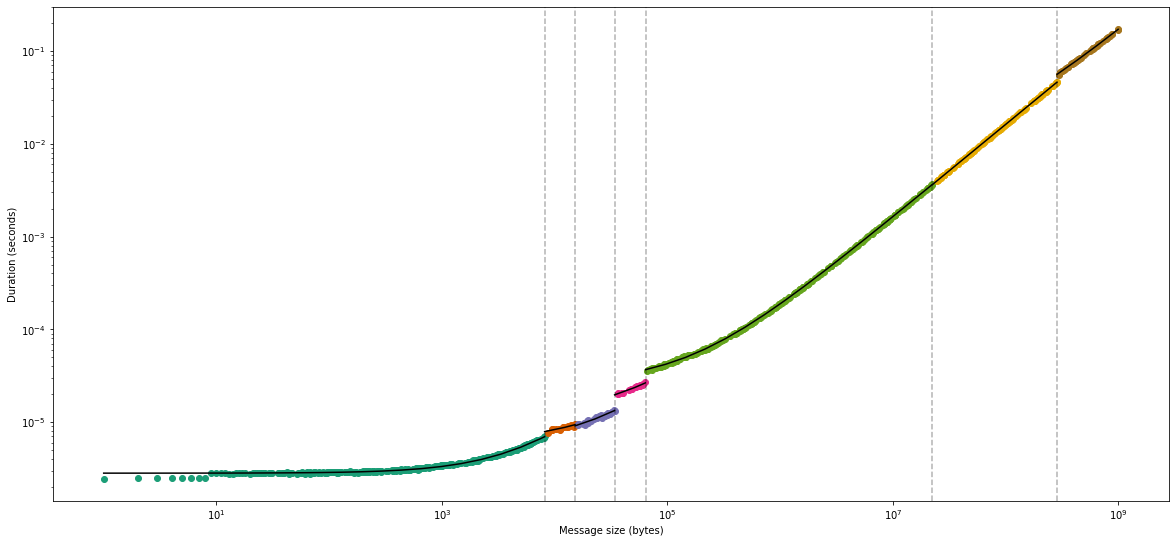

In [26]:
tmp = aggregate_dataframe(remote['pingpong'])
reg_pingpong = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration, breakpoints=breakpoints)
print(reg_pingpong)
draw_plot(reg_pingpong)

In [27]:
df_reg_recv = reg_recv.to_pandas()
df_reg_pingpong = reg_pingpong.to_pandas()
df_reg_transfer = df_reg_pingpong[['coefficient', 'intercept', 'max_x', 'min_x']].copy()
df_reg_transfer['coefficient'] /= 2
df_reg_transfer['intercept'] /= 2
df_reg_transfer.loc[df_reg_transfer['max_x'] <= threshold, 'coefficient'] -= df_reg_recv[df_reg_recv['max_x'] <= threshold]['coefficient']
df_reg_transfer.loc[df_reg_transfer['max_x'] <= threshold, 'intercept'] -= df_reg_recv[df_reg_recv['max_x'] <= threshold]['intercept']
df_reg_transfer

,coefficient,intercept,max_x,min_x
0,1.881130e-10,1.317253e-07,8141.0,-inf
1,2.781801e-11,1.970685e-06,15182.0,8141.0
2,3.652782e-11,1.712114e-06,33975.0,15182.0
3,3.484541e-11,4.861755e-06,64000.0,33975.0
4,8.096482e-11,1.318635e-05,22348146.0,64000.0
5,8.105246e-11,3.227764e-06,285420699.0,22348146.0
6,8.159399e-11,4.791763e-03,inf,285420699.0


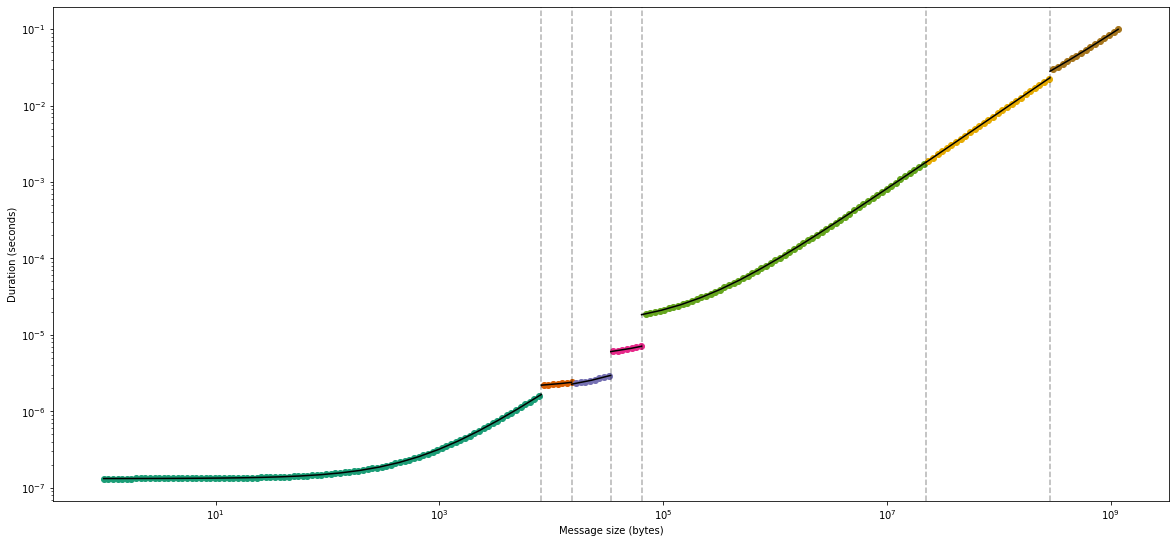

In [28]:
def predict(reg, x):
    for row in reg.iterrows():
        _, row = row
        if row.min_x <= x < row.max_x:
            return row.coefficient * x + row.intercept

tmp = pandas.DataFrame({'x': [1.1**i for i in range(220)]})
tmp['y'] = tmp.apply(lambda row: predict(df_reg_transfer, row.x), axis=1)
draw_plot(pytree.compute_regression(x=tmp.x, y=tmp.y, breakpoints=breakpoints))

In [29]:
df_reg_transfer['bandwidth_factor'] = 1/(df_reg_transfer.coefficient*expected_bandwidth)
df_reg_transfer['latency_factor']   = df_reg_transfer.intercept/expected_latency

pandas.set_option('display.float_format', lambda x: '%.2e' % x)
df_reg_transfer

,coefficient,intercept,max_x,min_x,bandwidth_factor,latency_factor
0,1.88e-10,1.32e-07,8.14e+03,-inf,4.25e-01,1.32e+00
1,2.78e-11,1.97e-06,1.52e+04,8.14e+03,2.88e+00,1.97e+01
2,3.65e-11,1.71e-06,3.40e+04,1.52e+04,2.19e+00,1.71e+01
3,3.48e-11,4.86e-06,6.40e+04,3.40e+04,2.30e+00,4.86e+01
4,8.10e-11,1.32e-05,2.23e+07,6.40e+04,9.88e-01,1.32e+02
5,8.11e-11,3.23e-06,2.85e+08,2.23e+07,9.87e-01,3.23e+01
6,8.16e-11,4.79e-03,inf,2.85e+08,9.80e-01,4.79e+04


In [30]:
bandwidth_str = regression_to_str(df_reg_transfer, drop_threshold=threshold, keys=['bandwidth_factor'])
latency_str = regression_to_str(df_reg_transfer, drop_threshold=threshold, keys=['latency_factor'])

print(bandwidth_str)
print(latency_str)

min_lat_factor = df_reg_transfer[df_reg_transfer.min_x == float('-inf')].latency_factor.min()
max_bw_factor = df_reg_transfer[df_reg_transfer.max_x == float('inf')].bandwidth_factor.max()

0:0.4252763902726342;8141:2.875834301436143;15182:2.1901117825797405;33975:2.2958545663029186;64000:0.9880834592098676;22348146:0.9870150479678867;285420699:0.9804644078221013
0:1.3172532811711535;8141:19.706846568054445;15182:17.12113866848863;33975:48.61754645707976;64000:131.86348210010948;22348146:32.277641671876054;285420699:47917.628671537845


### Wtime

9.4257625e-07


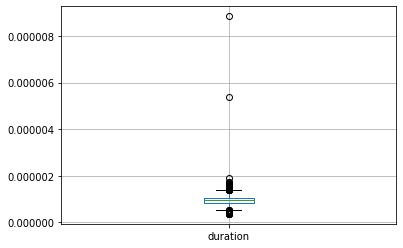

In [31]:
wtime_mean = remote['wtime'].duration.mean()
print(wtime_mean)
remote['wtime'].boxplot('duration')

### Test

8.194226137498864e-07


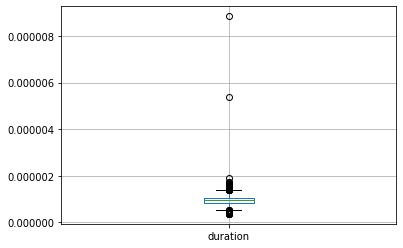

In [32]:
test_mean = remote['test'].duration.mean()
print(test_mean)
remote['wtime'].boxplot('duration')

### Iprobe

2.586894942676012e-07


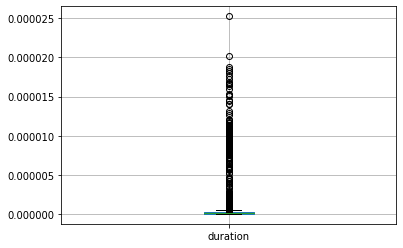

In [33]:
iprobe_mean = remote['iprobe'].duration.mean()
print(iprobe_mean)
remote['iprobe'].boxplot('duration')

## Loopback

In the next cells, we will compute the bandwidth and latency factors for the loopback. We will use the same `os`, `or` and `ois` values than for the remote communications however.

In [34]:
tmp = aggregate_dataframe(loopback['pingpong'])
reg_pingpong_loopback = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration)
print(reg_pingpong_loopback.breakpoints)
reg_pingpong_loopback = reg_pingpong_loopback.auto_simplify()
print(reg_pingpong_loopback.breakpoints)
reg_pingpong_loopback

[25, 8141, 15182, 832173, 970958, 4868751, 10487516, 11849406]
[11849406]


-inf < x ≤ 1.185e+07
	y ~ 1.497e-10x + -1.743e-06
1.185e+07 < x ≤ inf
	y ~ 3.649e-10x + -2.359e-04

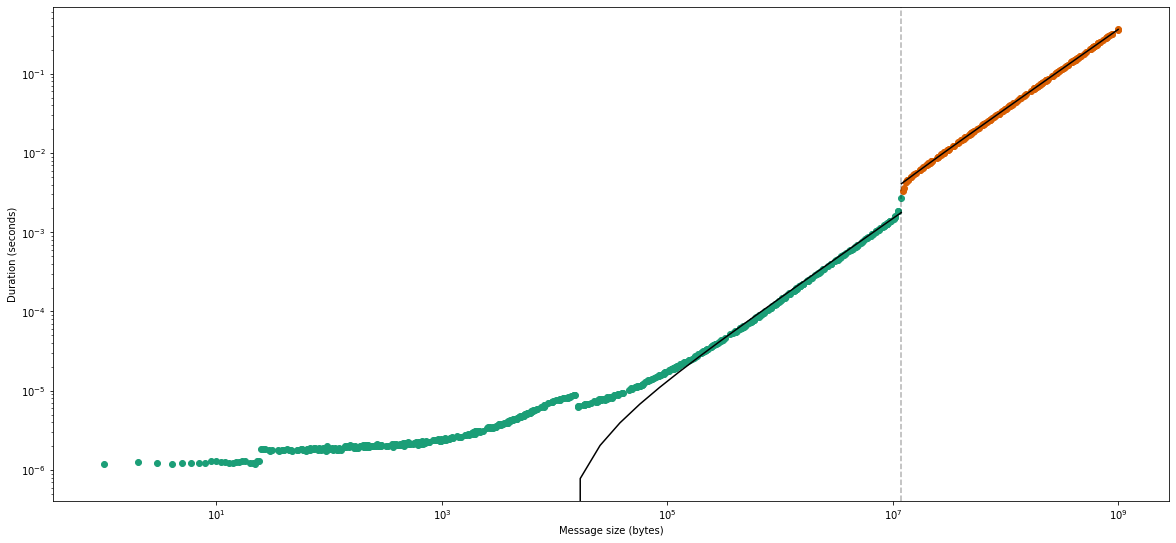

In [35]:
draw_plot(reg_pingpong_loopback)

[15182, 64000, 970958, 11849406]


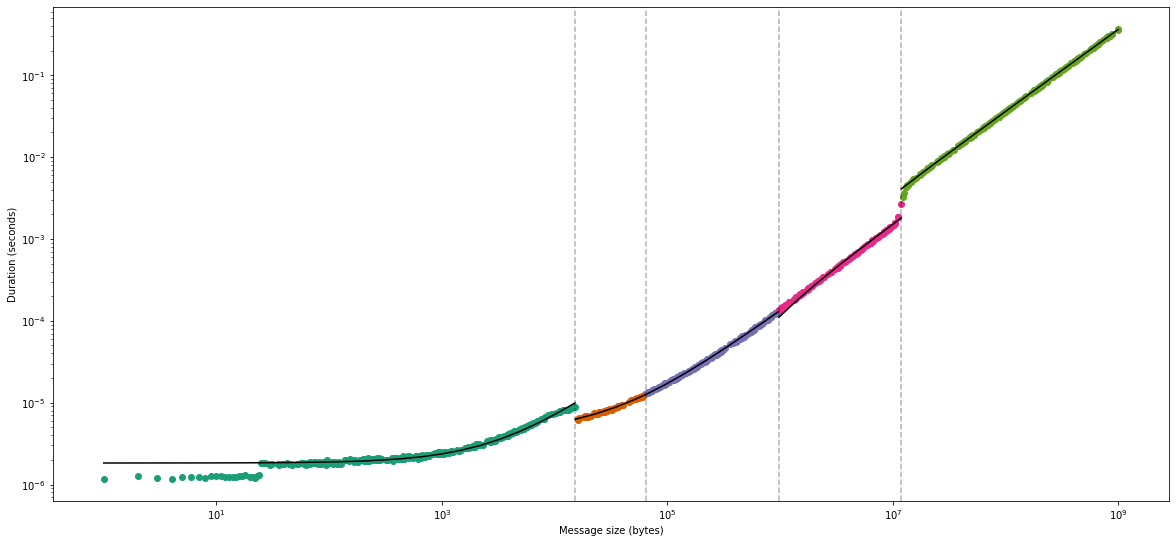

In [36]:
breakpoints_pingpong_loopback = list(sorted(set(reg_pingpong_loopback.breakpoints) | {15182, threshold, 970958}))
reg_pingpong_loopback = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration, breakpoints=breakpoints_pingpong_loopback)
draw_plot(reg_pingpong_loopback)
print(breakpoints_pingpong_loopback)

In [37]:
df_reg_pingpong_loopback = reg_pingpong_loopback.to_pandas()
df_reg_transfer_loopback = df_reg_pingpong_loopback[['coefficient', 'intercept', 'max_x', 'min_x']].copy()
df_reg_transfer_loopback['coefficient'] /= 2
df_reg_transfer_loopback['intercept'] /= 2
df_reg_transfer_loopback.loc[df_reg_transfer_loopback['max_x'] <= threshold, 'coefficient'] -= df_reg_recv[df_reg_recv['max_x'] <= threshold]['coefficient']
df_reg_transfer_loopback.loc[df_reg_transfer_loopback['max_x'] <= threshold, 'intercept'] -= df_reg_recv[df_reg_recv['max_x'] <= threshold]['intercept']

# A negative bandwidth or latency does not make sense 
df_reg_transfer_loopback.loc[df_reg_transfer_loopback['coefficient'] < 0, 'coefficient'] = 1/expected_loopback_bandwidth
df_reg_transfer_loopback.loc[df_reg_transfer_loopback['intercept'] < 0, 'intercept'] = 0
df_reg_transfer_loopback

,coefficient,intercept,max_x,min_x
0,2.01e-10,0.00e+00,1.52e+04,-inf
1,4.00e-11,1.04e-06,6.40e+04,1.52e+04
2,6.49e-11,2.11e-06,9.71e+05,6.40e+04
3,7.78e-11,0.00e+00,1.18e+07,9.71e+05
4,1.82e-10,0.00e+00,inf,1.18e+07


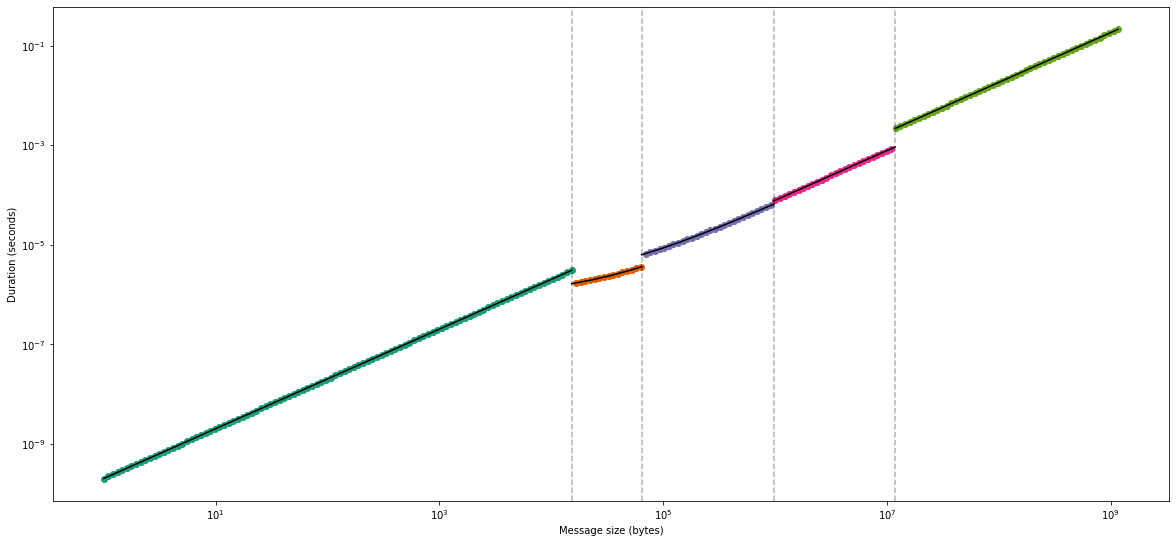

In [38]:
tmp = pandas.DataFrame({'x': [1.1**i for i in range(220)]})
tmp['y'] = tmp.apply(lambda row: predict(df_reg_transfer_loopback, row.x), axis=1)
draw_plot(pytree.compute_regression(x=tmp.x, y=tmp.y, breakpoints=breakpoints_pingpong_loopback))

In [39]:
df_reg_transfer_loopback['bandwidth_factor'] = 1/(df_reg_transfer_loopback.coefficient*expected_loopback_bandwidth)
df_reg_transfer_loopback['latency_factor']   = df_reg_transfer_loopback.intercept/expected_loopback_latency

pandas.set_option('display.float_format', lambda x: '%.2e' % x)
df_reg_transfer_loopback

,coefficient,intercept,max_x,min_x,bandwidth_factor,latency_factor
0,2.01e-10,0.00e+00,1.52e+04,-inf,1.99e-01,0.00e+00
1,4.00e-11,1.04e-06,6.40e+04,1.52e+04,1.00e+00,1.04e+01
2,6.49e-11,2.11e-06,9.71e+05,6.40e+04,6.16e-01,2.11e+01
3,7.78e-11,0.00e+00,1.18e+07,9.71e+05,5.14e-01,0.00e+00
4,1.82e-10,0.00e+00,inf,1.18e+07,2.19e-01,0.00e+00


In [40]:
loopback_bandwidth_str = regression_to_str(df_reg_transfer_loopback, drop_threshold=threshold, keys=['bandwidth_factor'])
loopback_latency_str = regression_to_str(df_reg_transfer_loopback, drop_threshold=threshold, keys=['latency_factor'])

print(loopback_bandwidth_str)
print(loopback_latency_str)

0:0.19917143744834562;15182:1.0000000000000002;64000:0.6160985009097961;970958:0.5141447080651341;11849406:0.2192398723267138
0:0.0;15182:10.39020499804664;64000:21.12883557364615;970958:0.0;11849406:0.0


## XML generation

In [41]:
config = f'''
<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="{reg_send_str}"/>
        <prop id="smpi/or" value="{reg_recv_str}"/>
        <prop id="smpi/ois" value="{reg_isend_str}"/>
        <prop id="smpi/bw-factor" value="{bandwidth_str}"/>
        <prop id="smpi/lat-factor" value="{latency_str}"/>
        <prop id="smpi/loopback-bw-factor" value="{loopback_bandwidth_str}"/>
        <prop id="smpi/loopback-lat-factor" value="{loopback_latency_str}"/>
        <prop id="smpi/async-small-thresh" value="{threshold}"/>
        <prop id="smpi/send-is-detached-thresh" value="{threshold}"/>
        <prop id="smpi/iprobe" value="{iprobe_mean}"/>
        <prop id="smpi/test" value="{test_mean}"/>
        <prop id="smpi/host-speed" value="1"/>
    </config>

    <AS id="AS0" routing="Full">
        <cluster id="cluster" prefix="dahu-" suffix=".grid5000.fr" radical="1-32" speed="1" core="32" bw="{expected_bandwidth*1e-9}GBps" lat="{expected_latency*1e6:.2f}us" loopback_bw="{expected_loopback_bandwidth*1e-9}GBps" loopback_lat="{expected_loopback_latency*1e6:.2f}us"/>
    </AS>
</platform>
'''

# Note: I removed the wtime property because I do not need it, feel free to add it back: <prop id="smpi/wtime" value="{wtime_mean}"/>

from IPython.display import display, Markdown
display(Markdown('```xml\n%s\n```' % config))

```xml

<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.502937424977244e-07:1.0245080259848237e-10;8141:3.539145436769647e-06:1.3325898763631872e-10;15182:3.614469229804382e-06:1.145222660235552e-10;33975:7.442771050909496e-06:1.45750515221467e-10;64000:0.0:0.0;22348146:0.0:0.0;285420699:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.2750423142473053e-06:6.626128067248632e-11;8141:1.1174370543426757e-06:7.776957755512856e-11;15182:1.14436008533479e-06:7.538525240549961e-11;33975:1.0993400801884101e-06:7.893103215998593e-11;64000:0.0:0.0;22348146:0.0:0.0;285420699:0.0:0.0"/>
        <prop id="smpi/ois" value="0:7.839303208881308e-07:6.213245167151483e-11;8141:4.7465736494455546e-07:1.1998589881677183e-10;15182:3.1633105340707003e-06:3.9237056543152315e-11;33975:3.398018956917037e-06:3.108376556546846e-11;64000:8.292606576826348e-07:8.229713360921498e-15;22348146:9.929024202226972e-07:2.048446537316319e-15;285420699:1.5372126903753094e-06:1.2198905891978087e-16"/>
        <prop id="smpi/bw-factor" value="0:0.4252763902726342;8141:2.875834301436143;15182:2.1901117825797405;33975:2.2958545663029186;64000:0.9880834592098676;22348146:0.9870150479678867;285420699:0.9804644078221013"/>
        <prop id="smpi/lat-factor" value="0:1.3172532811711535;8141:19.706846568054445;15182:17.12113866848863;33975:48.61754645707976;64000:131.86348210010948;22348146:32.277641671876054;285420699:47917.628671537845"/>
        <prop id="smpi/loopback-bw-factor" value="0:0.19917143744834562;15182:1.0000000000000002;64000:0.6160985009097961;970958:0.5141447080651341;11849406:0.2192398723267138"/>
        <prop id="smpi/loopback-lat-factor" value="0:0.0;15182:10.39020499804664;64000:21.12883557364615;970958:0.0;11849406:0.0"/>
        <prop id="smpi/async-small-thresh" value="64000"/>
        <prop id="smpi/send-is-detached-thresh" value="64000"/>
        <prop id="smpi/iprobe" value="2.586894942676012e-07"/>
        <prop id="smpi/test" value="8.194226137498864e-07"/>
        <prop id="smpi/host-speed" value="1"/>
    </config>

    <AS id="AS0" routing="Full">
        <cluster id="cluster" prefix="dahu-" suffix=".grid5000.fr" radical="1-32" speed="1" core="32" bw="12.5GBps" lat="0.10us" loopback_bw="25.0GBps" loopback_lat="0.10us"/>
    </AS>
</platform>

```

## Pretty plots

In [42]:
def pretty_plot(df, reg, n=10000):
    df = df.sample(n=n).copy()
    df['pred'] = df.apply(lambda row: reg.predict(row['msg_size']), axis=1)
    df['group'] = 0
    for i, bp in enumerate(reg.breakpoints):
        df.loc[df['msg_size'] > bp, 'group'] = i+1
    plot = ggplot(df) + geom_point(aes(x='msg_size', y='duration', color='factor(group)'), alpha=0.5, show_legend=False)
    breakpoints = list(reg.breakpoints)
    for bp in breakpoints:
        plot = plot + geom_vline(xintercept=bp, linetype='dashed', color='gray')
    breakpoints = [float('-inf')] + breakpoints + [float('inf')]
    for bp1, bp2 in zip(breakpoints[:-1], breakpoints[1:]):
        plot = plot + geom_line(df[(df.msg_size > bp1) & (df.msg_size < bp2)], aes(x='msg_size', y='pred'), size=1)
    plot = plot + theme_bw() + scale_x_log10() + scale_y_log10() + xlab('Message size (bytes)') + ylab('Duration (seconds)')
    op = df['op'].unique()[0]
    plot = plot + ggtitle('Durations of %s' % op)
    return plot

/home/tom/.cache/pypoetry/virtualenvs/mpi-calibration-V_fyVHYp-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 12 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/tom/.cache/pypoetry/virtualenvs/mpi-calibration-V_fyVHYp-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /tmp/recv.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


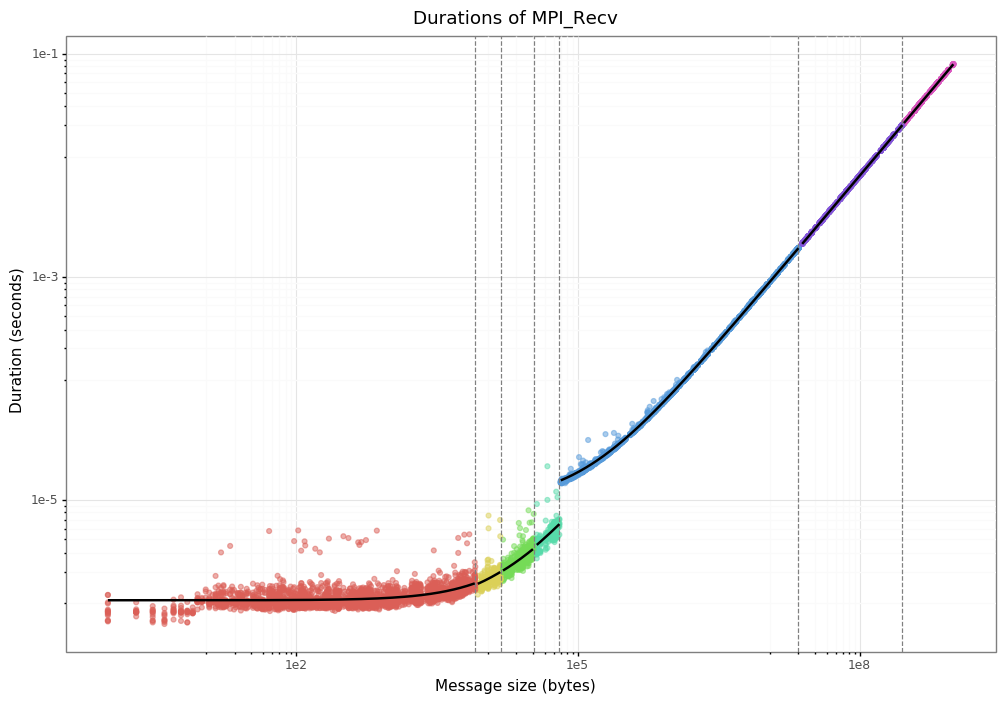

<ggplot: (8763021973410)>

In [43]:
plot = pretty_plot(remote['recv'], reg_recv)
plot.save('/tmp/recv.pdf')
plot

/home/tom/.cache/pypoetry/virtualenvs/mpi-calibration-V_fyVHYp-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 12 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/tom/.cache/pypoetry/virtualenvs/mpi-calibration-V_fyVHYp-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /tmp/send.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


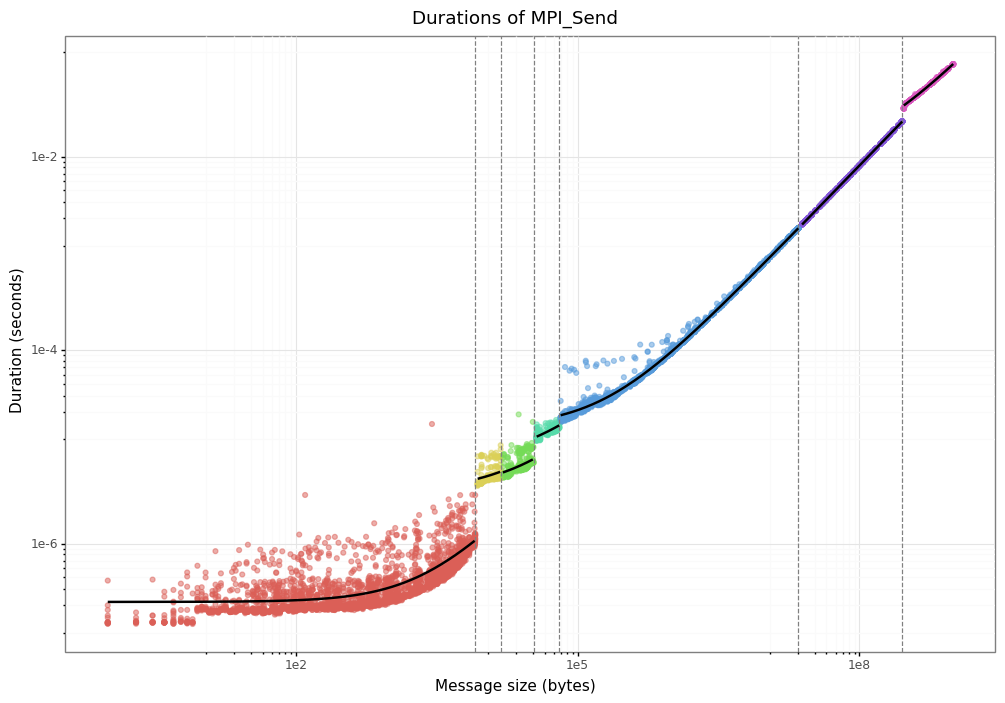

<ggplot: (8763015454384)>

In [44]:
plot = pretty_plot(remote['send'], reg_send)
plot.save('/tmp/send.pdf')
plot